<a href="https://colab.research.google.com/github/prashanth-acsq/Colab-Notebooks/blob/main/fgvc9/FGVC9_(R50%2C_Full%2C_NA256%2C_OCLR).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Bring Data Into Notebook**

In [ ]:
from time import time
start_time = time()

from IPython.display import clear_output
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!mkdir ~/.data
!kaggle kernels output prashanthacsq/fgvc9-images-256 -p /.data

clear_output()

print(f"Time Taken to download data : {(time()-start_time)/60:.2f} minutes")

Time Taken to download data : 1.51 minutes


In [ ]:
!ls /.data

fgvc9-images-256.log  images_256.npy  labels.npy


### **Library Imports**

In [ ]:
import os
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torchvision import models, transforms

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

### **Utilities and Constants**

In [ ]:
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRANSFORM = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.37250, 0.37591, 0.37537],
                                                     [0.20316, 0.21171, 0.21160]),
                                ])


SAVE_PATH = "/content/saves"
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

In [ ]:
def breaker(num: int=50, char: str="*") -> None:
    print("\n" + num*char + "\n")


def show_graphs(L: list, A: list) -> None:
    TL, VL, TA, VA = [], [], [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
        TA.append(A[i]["train"])
        VA.append(A[i]["valid"])
    x_Axis = np.arange(1, len(TL) + 1)
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x_Axis, TL, "r", label="Train")
    plt.plot(x_Axis, VL, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Loss Graph")
    plt.subplot(1, 2, 2)
    plt.plot(x_Axis, TA, "r", label="Train")
    plt.plot(x_Axis, VA, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Accuracy Graph")
    plt.show()

### **Configuration**

In [ ]:
class CFG(object):
    def __init__(self, 
                 seed: int = 42,
                 n_splits: int = 5,
                 batch_size: int = 16,
                 epochs: int = 25,
                 early_stopping: int = 5,
                 lr: float = 1e-4,
                 wd: float = 0.0,
                 max_lr: float = 1e-3,
                 pct_start: float = 0.2,
                 steps_per_epoch: int = 100,
                 div_factor: int = 1e3, 
                 final_div_factor: float = 1e3,
                 ):
        
        self.seed = seed
        self.n_splits = n_splits
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stopping = early_stopping
        self.lr = lr
        self.wd = wd
        self.max_lr = max_lr
        self.pct_start = pct_start
        self.steps_per_epoch = steps_per_epoch
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor
    
cfg = CFG(seed=SEED)

### **Dataset Template**

In [ ]:
class DS(Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray = None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        if self.labels is not None:
            return self.transform(self.images[idx]), torch.LongTensor(self.labels[idx])
        else:
            return self.transform(self.images[idx])

### **Model**

In [ ]:
class MyResnet(nn.Module):
    def __init__(self):
        super(MyResnet, self).__init__()

        self.model = models.resnet50(pretrained=True, progress=True)
        self.model.fc = nn.Linear(in_features=self.model.fc.in_features, out_features=100)

    def forward(self, x):
        return nn.LogSoftmax(dim=1)(self.model(x))

### **Fit and Predict Helper**

In [ ]:
def fit(model=None, 
        optimizer=None, 
        scheduler=None, 
        epochs=None, 
        early_stopping_patience=None, 
        dataloaders=None, 
        fold=None, 
        verbose=False) -> tuple:
    
    def get_accuracy(y_pred, y_true):
        y_pred = torch.argmax(y_pred, dim=1)
        return torch.count_nonzero(y_pred == y_true).item() / len(y_pred)
    
    if verbose:
        breaker()
        if fold: print(f"Training Fold {fold}...")
        else: print("Training ...")
        breaker()
        
    bestLoss, bestAccs = {"train" : np.inf, "valid" : np.inf}, {"train" : 0.0, "valid" : 0.0}
    Losses, Accuracies, LRs = [], [], []
    if fold: name = f"state_fold_{fold}.pt"
    else: name = "state.pt"

    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss, epochAccs = {"train" : 0.0, "valid" : 0.0}, {"train" : 0.0, "valid" : 0.0}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass, accsPerPass = [], []

            for X, y in dataloaders[phase]:
                X, y = X.to(DEVICE), y.to(DEVICE).view(-1)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = torch.nn.NLLLoss()(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        if scheduler: scheduler.step()
                lossPerPass.append(loss.item())
                accsPerPass.append(get_accuracy(output, y))
            epochLoss[phase] = np.mean(np.array(lossPerPass))
            epochAccs[phase] = np.mean(np.array(accsPerPass))
        LRs.append(scheduler.get_last_lr())
        Losses.append(epochLoss)
        Accuracies.append(epochAccs)
        
        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save({"model_state_dict"     : model.state_dict(),
                            "optim_state_dict"     : optimizer.state_dict(),
                            "scheduler_state_dict" : scheduler.state_dict()},
                           os.path.join(SAVE_PATH, name))
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e + 1))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save({"model_state_dict"     : model.state_dict(),
                        "optim_state_dict"     : optimizer.state_dict(),
                        "scheduler_state_dict" : scheduler.state_dict()},
                        os.path.join(SAVE_PATH, name))
        
        if epochAccs["valid"] > bestAccs["valid"]:
            bestAccs = epochAccs
            BAE = e + 1
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} |\
Train Accs: {:.5f} | Valid Accs: {:.5f} | Time: {:.2f} seconds".format(e+1, 
                                                                       epochLoss["train"], epochLoss["valid"], 
                                                                       epochAccs["train"], epochAccs["valid"], 
                                                                       time()-e_st))

    if verbose:                                           
        breaker()
        print(f"Best Validation Loss at Epoch {BLE}")
        breaker()
        print(f"Best Validation Accs at Epoch {BAE}")
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
    
    return Losses, Accuracies, LRs, BLE, BAE, name


# def predict(model=None, dataloader=None, path=None) -> np.ndarray:
#     model.load_state_dict(torch.load(path, map_location=DEVICE)["model_state_dict"])
#     model.to(DEVICE)    
#     model.eval()
    
#     y_pred = torch.zeros(1, 1).to(DEVICE)
    
#     for X in dataloader:
#         X = X.to(DEVICE)
#         with torch.no_grad():
#             output = torch.argmax(torch.exp(model(X)), dim=1)
#         y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    
#     return y_pred[1:].detach().cpu().numpy()

### **Train**

In [ ]:
images = np.load("/.data/images_256.npy")
labels = np.load("/.data/labels.npy")


**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 4.38109 | Valid Loss: 3.42175 |Train Accs: 0.06084 | Valid Accs: 0.21669 | Time: 176.79 seconds
Epoch: 2 | Train Loss: 2.40167 | Valid Loss: 1.16425 |Train Accs: 0.41843 | Valid Accs: 0.67513 | Time: 176.45 seconds
Epoch: 3 | Train Loss: 1.21918 | Valid Loss: 1.27539 |Train Accs: 0.65681 | Valid Accs: 0.62044 | Time: 175.97 seconds
Epoch: 4 | Train Loss: 1.08504 | Valid Loss: 2.20963 |Train Accs: 0.67610 | Valid Accs: 0.47588 | Time: 175.81 seconds
Epoch: 5 | Train Loss: 1.06759 | Valid Loss: 1.40417 |Train Accs: 0.68202 | Valid Accs: 0.60560 | Time: 176.31 seconds
Epoch: 6 | Train Loss: 1.02466 | Valid Loss: 2.12617 |Train Accs: 0.69511 | Valid Accs: 0.51410 | Time: 177.17 seconds
Epoch: 7 | Train Loss: 0.90678 | Valid Loss: 1.15789 |Train Accs: 0.72787 | Valid Accs: 0.66428 | Time: 176.86 seconds
Epoch: 8 | Train Loss: 0.81797 | Valid Loss: 2.2

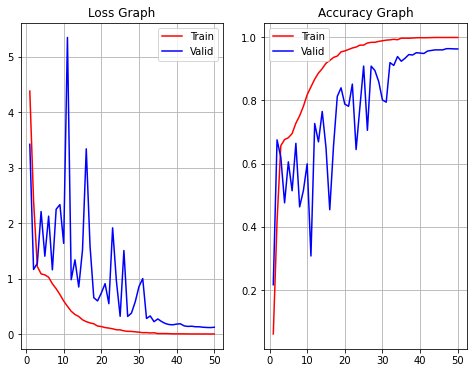

In [ ]:
for tr_idx, va_idx in StratifiedKFold(n_splits=cfg.n_splits, random_state=SEED, shuffle=True).split(images, labels):
    break

tr_images, va_images, tr_labels, va_labels = images[tr_idx], images[va_idx], labels[tr_idx], labels[va_idx]

tr_data_setup = DS(tr_images, tr_labels.reshape(-1, 1), TRANSFORM)
va_data_setup = DS(va_images, va_labels.reshape(-1, 1), TRANSFORM)

dataloaders = {
    "train" : DL(tr_data_setup, batch_size=cfg.batch_size, shuffle=True, generator=torch.manual_seed(cfg.seed)),
    "valid" : DL(va_data_setup, batch_size=cfg.batch_size, shuffle=False),
}

cfg = CFG(epochs=50, steps_per_epoch=len(dataloaders["train"]))

torch.manual_seed(SEED)
model = MyResnet().to(DEVICE)
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, 
                                          max_lr=cfg.max_lr, 
                                          epochs=cfg.epochs, 
                                          steps_per_epoch=cfg.steps_per_epoch,
                                          pct_start=cfg.pct_start, 
                                          div_factor=cfg.div_factor, 
                                          final_div_factor=cfg.final_div_factor)

L, A, LRs, BLE, BAE, name = fit(model=model, 
                                optimizer=optimizer, 
                                scheduler=scheduler, 
                                epochs=cfg.epochs, 
                                early_stopping_patience=cfg.early_stopping, 
                                dataloaders=dataloaders,  
                                verbose=True)

breaker()
show_graphs(L, A)

In [ ]:
# from google.colab import drive
# drive.mount("/content/gdrive")

!cp "/content/saves/state.pt" "/content/gdrive/My Drive/Models/fgvc9/resnet50-state.pt"